# heiDS ArchEHR-QA 2025 Pipeline

## Required libraries

In [ ]:
!pip install -qU langchain-community langchain-huggingface huggingface_hub langchain-core faiss-gpu-cu11

In [ ]:
!pip install -qU flashrank cohere langchain_cohere ruptures evaluate bert_score fuzzywuzzy rouge_score

In [ ]:
!pip install -qU "numpy<2.0.0" "transformers==4.37.0"

❗Restart Session❗: Due to packages mismatch, kindly restart session

In [ ]:
!pip install -qU context-cite langchain-community langchain-huggingface huggingface_hub langchain-core faiss-gpu-cu11

In [ ]:
!pip install -qU flashrank cohere langchain_cohere ruptures evaluate bert_score fuzzywuzzy rouge_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Dataset Statistics: Analysis of provided case studies in development and test set

In [ ]:
import matplotlib.pyplot as plt
from typing import List, Union, Optional, Tuple
import numpy as np
import json
import pandas as pd
import statistics
import seaborn as sns

def histogram_plot(
    lengths: List[Union[int, float]],
    xlim: Optional[Union[List, Tuple[int, int]]] = None,
    ylim: Optional[Union[List, Tuple[int, int]]] = None,
    bins: int = 10,
    fp: str = "./histogram.png",
    title: str = "Histogram",
    xlabel: str = "Values",
    ylabel: str = "Frequency"
    ) -> None:
    mean_length = np.mean(lengths)
    median_value = np.median(lengths)

    try:
        mode_value = statistics.mode(lengths)  # Using mode from statistics module
    except statistics.StatisticsError:
        mode_value = None  # Handle case where there is no unique mode

    std_dev_length = np.std(lengths)
    bins_value = range(min(lengths), max(lengths) + 1)

    if xlim is None:
        xlim = (min(lengths), max(lengths))
    if ylim is None:
        ylim = (0, np.histogram(lengths, bins=bins_value)[0].max())

    print(f"Mean Length: {mean_length}")
    plt.hist(lengths, range=xlim, bins=bins_value, color="#1b9e77")
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Mean and std lines
    plt.axvline(
        mean_length,
        color="r",
        linestyle="solid",
        linewidth=2,
        label=f"Mean: {mean_length:.2f}",
    )
    plt.axvline(
        mean_length - std_dev_length,
        color="g",
        linestyle="dotted",
        linewidth=1,
        label="Std Dev",
    )
    plt.axvline(
        mean_length + std_dev_length,
        color="g",
        linestyle="dotted",
        linewidth=1,
        label="Std Dev",
    )

    plt.axvline(
        median_value,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {median_value:.2f}"
        )

    if mode_value is not None:
        plt.axvline(
            mode_value,
            color="orange",
            linestyle="dashed",
            linewidth=2,
            label=f"Mode: {mode_value}"
            )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Title and save
    plt.savefig(fp, dpi=300)
    plt.show()
    plt.close()


# Function to plot the box plot
def box_plot(
    lengths: List[Union[int, float]],
    fp: str = "./boxplot.png",
    title: str = "Box Plot of Relevant Sentences",
    ylabel: str = "Number of Relevant Sentences"
) -> None:
    """
    Function to plot a box plot for sentence distribution.
    """
    plt.figure(figsize=(4, 3))
    plt.boxplot(lengths, vert=True, patch_artist=True, boxprops=dict(facecolor="#1b9e77", color="black"))
    plt.ylabel(ylabel)
    plt.title(title)

    # Save and show the plot
    plt.savefig(fp, dpi=300)
    plt.show()
    plt.close()

In [ ]:
import xml.etree.ElementTree as ET
from typing import List, Dict
import os

def analyze_xml_cases(xml_file_path: str) -> List[Dict]:
    """
    Parses an XML file and computes the number of note_excerpt_sentences per case.

    Parameters:
        xml_file_path (str): Path to the XML file.

    Returns:
        List[Dict]: List containing case_id and number of sentences for each case.
    """
    if not os.path.exists(xml_file_path):
        raise FileNotFoundError(f"XML file not found at: {xml_file_path}")

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    sentence_stats = []
    for case in root.findall('case'):
        case_id = case.attrib.get('id')
        sentences = case.find('note_excerpt_sentences')
        sentence_elements = sentences.findall('sentence') if sentences is not None else []
        sentence_count = len(sentence_elements)

        sentence_stats.append({
            "case_id": case_id,
            "number_of_note_excerpt_sentences": sentence_count
        })

    return sentence_stats

Maximum number of note_excerpt_sentences in any case: 54


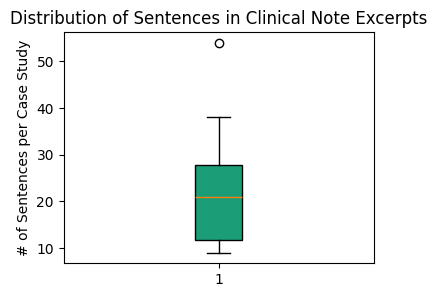

In [ ]:
if __name__ == "__main__":
    xml_file_path = "./dataset/development/archehr-qa.xml"  # Replace with actual path

    # Analyze the XML file
    case_sentence_stats = analyze_xml_cases(xml_file_path)

    # Compute max number of sentences
    sentence_counts = [stat["number_of_note_excerpt_sentences"] for stat in case_sentence_stats]
    max_sentences = max(stat["number_of_note_excerpt_sentences"] for stat in case_sentence_stats)
    print(f"Maximum number of note_excerpt_sentences in any case: {max_sentences}")

    # Get the distribution of sentence counts
    sentence_counts = [stat["number_of_note_excerpt_sentences"] for stat in case_sentence_stats]

    # Plot Box Plot
    box_plot(
        sentence_counts,
        fp="./note_excerpt_sentences_boxplot.png",
        title="Distribution of Sentences in Clinical Note Excerpts",
        ylabel="# of Sentences per Case Study"
    )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from typing import List
import numpy as np

# Function to extract all sentence texts from a given XML file
def extract_sentences_from_xml(xml_path: str) -> List[str]:
    """
    Extracts all note excerpt sentences from a given XML file.

    Args:
        xml_path (str): Path to the XML file.

    Returns:
        List[str]: All sentence texts extracted from <note_excerpt_sentences>.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    sentences = []
    for case in root.findall('case'):
        note_excerpt_sentences = case.find('note_excerpt_sentences')
        if note_excerpt_sentences is not None:
            for sentence_elem in note_excerpt_sentences.findall('sentence'):
                sent_text = sentence_elem.text
                if sent_text:
                    sentences.append(sent_text.strip())
    return sentences

def plot_sentence_length_distribution(
    dev_sentences: List[str],
    test_sentences: List[str],
    measure: str = "tokens",  # Options: "tokens" or "characters"
    bins: int = 30,
    dev_fp: str = "./dev_sentence_length_histogram.png",
    test_fp: str = "./test_sentence_length_histogram.png"
) -> None:
    """
    Plot sentence length histograms (with annotations) for dev and test sets using histogram_plot.
    """
    if measure == "characters":
        dev_lengths = [len(s) for s in dev_sentences]
        test_lengths = [len(s) for s in test_sentences]
        xlabel = "Sentence Length (in Characters)"
    elif measure == "tokens":
        dev_lengths = [len(s.split()) for s in dev_sentences]
        test_lengths = [len(s.split()) for s in test_sentences]
        xlabel = "Sentence Length (in Tokens)"
    else:
        raise ValueError("Invalid measure: choose 'tokens' or 'characters'")

    # Dev set histogram
    histogram_plot(
        dev_lengths,
        bins=bins,
        fp=dev_fp,
        title="Sentence Length Distribution in Development Set",
        xlabel=xlabel,
        ylabel="Frequency"
    )

    # Test set histogram
    histogram_plot(
        test_lengths,
        bins=bins,
        fp=test_fp,
        title="Sentence Length Distribution in Test Set",
        xlabel=xlabel,
        ylabel="Frequency"
    )

Mean Length: 14.995327102803738


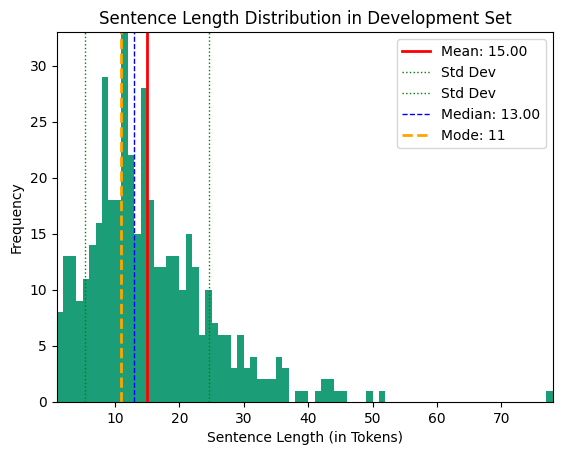

Mean Length: 14.63716814159292


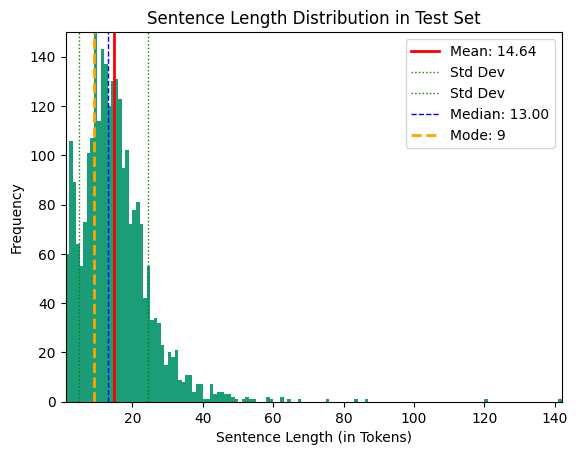

In [ ]:
if __name__ == "__main__":
    # File paths (update as needed)
    dev_xml_file = "./dataset/development/archehr-qa.xml"
    test_xml_file = "./dataset/test/archehr-qa.xml"

    # Step 1: Extract sentences
    dev_sentences = extract_sentences_from_xml(dev_xml_file)
    test_sentences = extract_sentences_from_xml(test_xml_file)

    # Step 2: Plot sentence length distributions
    plot_sentence_length_distribution(
        dev_sentences,
        test_sentences,
        measure="tokens",  # or "characters"
        bins=30,
        dev_fp="./dev_sentence_length_histogram.png",
        test_fp="./test_sentence_length_histogram.png"
    )

## Proposed Pipeline

In [ ]:
import os
import xml.etree.ElementTree as ET
import faiss
import re
import string
import nltk
import json
import numpy as np
import math
import time
import gc
from dataclasses import dataclass
from uuid import uuid4
from torch import cuda
from typing import List, Dict, Optional

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from huggingface_hub import InferenceClient
from transformers import AutoTokenizer, AutoModelForCausalLM

# Downloading required NLTK packages.
nltk.download('punkt_tab')

### 🔪 Dynamic Truncation Components 🔪


⚠️ **Note** ⚠️

- The code for **autocut** is converted from Go language considering the official implementation of autocut present in Weaviate. [Link](https://github.com/weaviate/weaviate/tree/main/entities/autocut)

- Acknowledgement to the code for the paper [Ranked List Truncation for Large Language Model-based Re-Ranking](https://dl.acm.org/doi/10.1145/3626772.3657864) for implementation of **surprise** code.

In [ ]:
from numpy import matlib
import ruptures as rpt
import attr
from scipy.stats import genpareto
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

@attr.s
class Gpd(object):
    k = attr.ib()
    a = attr.ib()

    def cdf(self, x):
        if self.k == 0:
            return 1 - np.exp(-x / self.a)
        else:
            return 1 - np.power(1 - self.k * x / self.a, 1.0 / self.k)

    def pdf(self, x):
        if self.k == 0:
            pass
        else:
            return (
                1.0
                / self.a
                * np.power(1 - self.k * x / self.a, (1.0 - self.k) / self.k)
            )

    @classmethod
    def fit(cls, vals):
        eps = 1e-6 / np.mean(vals)
        c, _, scale = genpareto.fit(vals, loc=0)
        theta = min(-c / scale, -eps)
        k = -1.0 / len(vals) * np.sum(np.log(1 - theta * vals))
        a = k / theta
        return cls(k=k, a=a)


class dynamicK:
    def __init__(self, similarity_values) -> None:
        """
        Initializes a ragChat object with specified configurations for text retrieval and generation.
        """
        self.cosine_similarities = similarity_values

    def autocut(self):
        # Weviate Approach
        if len(self.cosine_similarities) <= 1:
            return len(self.cosine_similarities)

        diff = [0] * len(self.cosine_similarities)
        step = 1.0 / (len(self.cosine_similarities) - 1)

        for i in range(len(self.cosine_similarities)):
            x_value = 0.0 + i * step
            y_value_norm = (
                self.cosine_similarities[i] - self.cosine_similarities[0]
            ) / (self.cosine_similarities[-1] - self.cosine_similarities[0])
            diff[i] = y_value_norm - x_value

        extrema_count = 0
        for i in range(
            1, len(diff)
        ):  # start from 1 since we don't consider the first element for extrema checking
            if (
                i == len(diff) - 1 and len(diff) > 1
            ):  # for the last element there is no "next" point
                if diff[i] > diff[i - 1] and diff[i] > diff[i - 2]:
                    extrema_count += 1
                    if extrema_count >= 1:
                        return i
            else:
                if diff[i] > diff[i - 1] and diff[i] > diff[i + 1]:
                    extrema_count += 1
                    if extrema_count >= 1:
                        return i

        return len(self.cosine_similarities)

    def autocut_star(self):
        """
        Dynamic Breaking Point Determination Using a First-Derivative approach
        Calculates the first derivative of the similarity scores to detect significant drops.
        Uses the mean and standard deviation of the changes to set a dynamic threshold.
        Finds the breaking point where the drop in similarity exceeds this dynamic threshold.

        Args:
            cosine_similarities (list): List of cosine similarities values in descending order

        Returns:
            breaking_point: Index of the point in the ranked list
        """
        # Compute the first derivative of similarities
        # First Derivative: Measures changes in similarity scores between consecutive documents.
        # First Derivative (Rate of Change): Helps you identify where the similarity between your query and documents is changing quickly. A big drop in this
        # value can signal that one is moving from relevant to less relevant documents.
        similarity_changes = np.diff(self.cosine_similarities)

        # Determine a dynamic threshold for a significant drop
        mean_change = np.mean(similarity_changes)
        std_change = np.std(similarity_changes)
        dynamic_threshold = mean_change - std_change

        # Find the breaking point where the drop exceeds the dynamic threshold
        breaking_point = (
            np.argmax(similarity_changes < dynamic_threshold) + 1
        )  # +1 to account for the diff shift

        return breaking_point


    def surprise_truncation(self):
        x = [
            self.cosine_similarities[i] / max(self.cosine_similarities)
            for i in range(len(self.cosine_similarities))
        ]
        all_scores = x.copy()
        all_scores = sorted(all_scores)
        j_hat = len(all_scores)
        for j_hat in range(len(all_scores), 0, -1):
            i_hat = 0
            self.cosine_similarities = self.cosine_similarities[:j_hat]
            excess = [
                all_scores[i] - all_scores[i_hat] for i in range(i_hat, j_hat - i_hat)
            ]

            tmp_scores = excess.copy()
            tmp_scores = np.array(tmp_scores)

            gpd_object = Gpd(
                k=len(all_scores) - j_hat, a=self.cosine_similarities[i_hat]
            )
            gpd_fitted = gpd_object.fit((tmp_scores))

            cdf_f = gpd_fitted.cdf(tmp_scores)
            m = j_hat - i_hat
            w2 = 0
            for i in range(i_hat, j_hat):
                w2 += math.pow(cdf_f[i] - (2 * (i + 1) - 1) / (2 * m), 2)
            w2 += 1 / (12 * m)

            if j_hat == len(all_scores) and i_hat == 0:
                previous_value = w2
            elif w2 > (previous_value):
                break
            else:
                j_hat -= 1

        for i_hat in range(0, j_hat):
            excess = [all_scores[i] - all_scores[i_hat] for i in range(i_hat, j_hat)]

            tmp_scores = excess.copy()
            tmp_scores = np.array(tmp_scores)

            gpd_object = Gpd(
                k=len(all_scores) - j_hat, a=self.cosine_similarities[i_hat]
            )
            gpd_fitted = gpd_object.fit((tmp_scores))

            cdf_f = gpd_fitted.cdf(tmp_scores)
            m = j_hat - i_hat
            w2 = 0
            for i in range(0, len(tmp_scores)):
                w2 += math.pow(cdf_f[i] - (2 * (i + 1) - 1) / (2 * m), 2)
            w2 += 1 / (12 * m)

            if j_hat == len(all_scores) and i_hat == 0:
                previous_value = w2
            if w2 > (previous_value):
                break
            else:
                i_hat += 1

        gpd_fitted = Gpd(k=len(all_scores) - j_hat, a=all_scores[i_hat])
        revised_surprise = []
        gpd_fitted = gpd_object.fit((tmp_scores))
        cdf_f = gpd_fitted.cdf(tmp_scores)

        for k in range(i_hat, len(all_scores)):
            revised_surprise.append(
                -math.log(1 - gpd_fitted.cdf(all_scores[k] - all_scores[i_hat]))
            )

        cut_off = i_hat
        for i in range(len(revised_surprise)):
            if revised_surprise[i] < all_scores[i_hat]:
                cut_off += 1
            else:
                break

        return len(self.cosine_similarities) - cut_off

    def find_elbow_point(self):
        """
        Elbow Approach:
        “elbow” point in the ranked list is often indicative of a significant drop in similarity values,
        suggesting a natural partition.

        This function computes the perpendicular distance of each point from the line formed by
        the first and the last points in the list. The point with the maximum distance
        is likely the elbow, suggesting a natural cutoff.

        Advantages:
        - This method works well in scenarios where there’s a CLEAR DROP in similarity values,
        signaling a natural partition in the dataset.

        Disadvantages:
        - Lack of Clear Segmentation:
            If the ranked list does not inherently contain distinct segments or changes, method might fail
            to identify meaningful truncation points.

        Args:
            cosine_similarities (list): List of cosine similarities values in descending order

        Returns:
            idx_of_max: Index of the point in the ranked list where distance from the line is maximum, i.e.,
                        likely the elbow.
        """
        # Convert list to array for easier manipulation
        similarities = np.array(self.cosine_similarities)
        n_points = len(similarities)
        all_coords = np.vstack((range(n_points), similarities)).T

        # Get line between first and last point
        first_point = all_coords[0]
        last_point = all_coords[-1]
        line_vec = last_point - first_point

        # Calculate the line vector norms
        line_vec_norm = np.sqrt(sum(line_vec**2))

        # Calculate the vector between all points and the first point
        vec_from_first = all_coords - first_point

        # Calculate the component of each point vector in the direction of the line vector
        scalar_product = np.sum(
            vec_from_first * np.matlib.repmat(line_vec, n_points, 1), axis=1
        )
        vec_from_first_parallel = np.outer(scalar_product, line_vec) / line_vec_norm**2

        # Compute the distance from each point to the line:
        vec_to_line = vec_from_first - vec_from_first_parallel

        # Distance from point to the line
        dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))

        # Index of the point with maximum distance to the line
        idx_of_max = np.argmax(dist_to_line)

        return idx_of_max

### Retrieval Evaluation

In [ ]:
class RetrievalEvaluator:
    """
    Evaluates the retrieval performance of the system using precision, recall, F1-score, and accuracy.
    Computes scores for essential sentences, supplementary sentences, and total relevant sentences.
    """

    def __init__(self, ground_truth_file: str, retrieved_results: Dict[str, List[str]]):
        """
        Initialize the evaluator with ground truth and retrieved results.

        Parameters:
            ground_truth_file (str): Path to the JSON file containing ground truth relevance information.
            retrieved_results (dict): Dictionary where keys are case_ids and values are lists of retrieved sentence_ids.
        """
        self.ground_truth_file = ground_truth_file
        self.retrieved_results = retrieved_results
        self.ground_truth_data = self.load_ground_truth()

    def load_ground_truth(self) -> Dict[str, Dict]:
        """
        Load and parse the ground truth JSON file.

        Returns:
            Dict[str, Dict]: A dictionary with case_id as keys and values containing essential, supplementary,
                             and combined relevant sentence IDs.
        """
        with open(self.ground_truth_file, 'r') as f:
            data = json.load(f)

        ground_truth = {}

        for case in data:
            case_id = case.get("case_id")
            essential_sentences = set()
            supplementary_sentences = set()

            for answer in case.get("answers", []):
                sentence_id = answer.get("sentence_id")
                relevance = answer.get("relevance", "").lower()
                if relevance == "essential":
                    essential_sentences.add(sentence_id)
                elif relevance == "supplementary":
                    supplementary_sentences.add(sentence_id)

            all_relevant_sentences = essential_sentences.union(supplementary_sentences)

            ground_truth[case_id] = {
                "essential": essential_sentences,
                "supplementary": supplementary_sentences,
                "total_relevant": all_relevant_sentences
            }

        return ground_truth


    def compute_metrics(self, relevant: set, retrieved: set) -> Dict[str, float]:
        """
        Compute precision, recall, F1-score, and accuracy.

        Parameters:
            relevant (set): The ground truth relevant sentences.
            retrieved (set): The retrieved sentences by the system.

        Returns:
            Dict[str, float]: A dictionary containing precision, recall, F1-score, and accuracy.
        """
        tp = len(relevant & retrieved)  # True Positives (correctly retrieved)
        fp = len(retrieved - relevant)  # False Positives (incorrectly retrieved)
        fn = len(relevant - retrieved)  # False Negatives (missed relevant)
        tn = 0  # True Negatives are not explicitly computed in sentence retrieval.

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0  # Approximate accuracy

        return {
            "Precision": round(precision, 2),
            "Recall": round(recall, 2),
            "F1-score": round(f1, 2),
            "Accuracy": accuracy  # Accuracy is not rounded for better differentiation
        }

    def evaluate(self) -> Dict[str, Dict]:
        """
        Perform the evaluation across all cases and compute macro-averaged scores.

        Returns:
            Dict[str, Dict]: A dictionary containing per-category and macro-averaged metrics.
        """
        essential_metrics = {"Precision": [], "Recall": [], "F1-score": [], "Accuracy": []}
        supplementary_metrics = {"Precision": [], "Recall": [], "F1-score": [], "Accuracy": []}
        total_relevant_metrics = {"Precision": [], "Recall": [], "F1-score": [], "Accuracy": []}

        for case_id, ground_truth in self.ground_truth_data.items():
            # retrieved_sentences = set(self.retrieved_results.get(case_id, []))
            retrieved_sentences = set(
                str(int(sid) - 1) for sid in self.retrieved_results.get(case_id, []) if sid.isdigit()
                )

            # Compute metrics for each category
            essential_scores = self.compute_metrics(ground_truth["essential"], retrieved_sentences)
            supplementary_scores = self.compute_metrics(ground_truth["supplementary"], retrieved_sentences)
            total_relevant_scores = self.compute_metrics(ground_truth["total_relevant"], retrieved_sentences)

            # Store the results
            for key in essential_metrics:
                essential_metrics[key].append(essential_scores[key])
                supplementary_metrics[key].append(supplementary_scores[key])
                total_relevant_metrics[key].append(total_relevant_scores[key])

        print(f"Essential Metrics: {essential_metrics}")
        print("-"*50)
        print(f"Supplementary Metrics: {supplementary_metrics}")
        print("-"*50)
        print(f"Total Relevant Metrics: {total_relevant_metrics}")
        print("-"*50)

        # Compute macro-averaged scores
        macro_essential = {
            key: round(np.mean(values), 2) if key in ["Precision", "Recall", "F1-score"] else np.mean(values)
            for key, values in essential_metrics.items()
        }
        macro_supplementary = {
            key: round(np.mean(values), 2) if key in ["Precision", "Recall", "F1-score"] else np.mean(values)
            for key, values in supplementary_metrics.items()
        }
        macro_total_relevant = {
            key: round(np.mean(values), 2) if key in ["Precision", "Recall", "F1-score"] else np.mean(values)
            for key, values in total_relevant_metrics.items()
        }

        return {
            "Essential Sentences": macro_essential,
            "Supplementary Sentences": macro_supplementary,
            "Total Relevant Sentences": macro_total_relevant
        }

### Preprocessing and XML Extraction

In [ ]:
class ClinicalPreprocessor:
    def __init__(self):
        pass

    # ---------------------- Pre-processing Functions ----------------------
    def normalize_whitespace(self, text: str) -> str:
        """Replace newline characters and multiple spaces with a single space."""
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def remove_extraneous_characters(self, text: str) -> str:
        """
        Remove extraneous characters and artifacts (e.g., extra quotes, escape sequences,
        non-printable characters).
        """
        text = re.sub(r'\\[tr]', ' ', text)
        text = re.sub(r'["“”‘’]+', '', text)
        text = re.sub(r'[^\x20-\x7E]', '', text)
        return text.strip()

    def remove_punctuation(self, text: str) -> str:
        """Remove punctuation from the text."""
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)

    def preprocess_text_chunk(self, text: str,
                              lowercase: bool = True,
                              remove_punct: bool = True,
                              do_lemmatize: bool = True,
                              remove_stop: bool = False) -> str:
        """
        Preprocess a text chunk to enhance semantic search precision and recall.
        """
        text = self.normalize_whitespace(text)
        text = self.remove_extraneous_characters(text)

        if lowercase:
            text = text.lower()

        if remove_punct:
            text = self.remove_punctuation(text)

        return text

In [ ]:
# ---------------------------
# XML Extraction and Parsing
# ---------------------------
class XMLCaseExtractor:
    """
    Extracts cases from the XML file.
    For each case, it extracts:
      - note_excerpt_sentences as Documents.
      - patient_narrative.
      - clinician_question.
    The patient query used for retrieval is created by combining the patient narrative (context) and the clinician question.
    """
    def __init__(self, xml_file: str):
        self.xml_file = xml_file
        self.preprocessor = ClinicalPreprocessor()

    def parse_xml(self) -> Dict[str, Dict]:
        """
        Parses the XML file and returns a dictionary with case ids as keys.
        For each case, the value is a dictionary with:
          - 'documents': a list of Document objects for note_excerpt_sentences.
          - 'patient_narrative': the patient narrative text.
          - 'clinician_question': the clinician question text.
          - 'retrieval_query': a combination of patient narrative and clinician question.
        """
        tree = ET.parse(self.xml_file)
        root = tree.getroot()
        cases = {}
        for case_elem in root.findall("case"):
            case_id = case_elem.get("id")
            # Extract note excerpt sentences as Documents.
            documents = []
            note_excerpts = case_elem.find("note_excerpt_sentences")
            if note_excerpts is not None:
                for sent_elem in note_excerpts.findall("sentence"):
                    # text = sent_elem.text.strip() if sent_elem.text else ""
                    # cleaned_text = text # NEEDS TO BE CHANGED
                    text = sent_elem.text.strip() if sent_elem.text else ""
                    preprocessed_text = self.preprocessor.preprocess_text_chunk(text)
                    sentence_id = sent_elem.get("id")
                    paragraph_id = sent_elem.get("paragraph_id")
                    start_char_index = int(sent_elem.get("start_char_index", "0"))
                    length = int(sent_elem.get("length", len(text)))
                    metadata = {
                        "case_id": case_id,
                        "sentence_id": sentence_id,
                        "paragraph_id": paragraph_id,
                        "start_char_index": start_char_index,
                        "length": length,
                        "original_text": text,
                        "cleaned_text": preprocessed_text.strip()
                    }
                    doc = Document(page_content=preprocessed_text.strip(), metadata=metadata)
                    documents.append(doc)

            # Extract patient narrative.
            patient_narrative_elem = case_elem.find("patient_narrative")
            patient_narrative = ""
            if patient_narrative_elem is not None and patient_narrative_elem.text:
                patient_narrative_text = patient_narrative_elem.text.strip()
                patient_narrative = self.preprocessor.preprocess_text_chunk(patient_narrative_text).strip()

            # Extract clinician question.
            clinician_question_elem = case_elem.find("clinician_question")
            clinician_question = ""
            if clinician_question_elem is not None and clinician_question_elem.text:
                clinician_question_text = clinician_question_elem.text.strip()
                clinician_question = self.preprocessor.preprocess_text_chunk(clinician_question_text).strip()

            # Construct the retrieval query by combining both elements.
            retrieval_query = f"Patient Narrative: {patient_narrative}\nClinician Question: {clinician_question}"
            cases[case_id] = {
                "documents": documents,
                "patient_narrative": patient_narrative,
                "clinician_question": clinician_question,
                "retrieval_query": retrieval_query
            }
        return cases

### Answer Generation Code

In [ ]:
from google.colab import userdata
hf_auth = userdata.get('HUGGINGFACEHUB_API_TOKEN')

# Use spaCy for sentence splitting.
import spacy

# ---------------------------
# Transformer Model for Answer Generation
# ---------------------------
class ClinicalAnswerGenerator:
    """
    Uses the HuggingFace Inference Endpoint for the Asclepius-Mistral-7B-v0.3 model
    to generate an answer given the retrieved note fragments, patient narrative context,
    and the precise clinician question.
    """
    # Since loading is taking a lot of space and time
    # def __init__(self, repo_id: str = "starmpcc/Asclepius-Llama2-13B"): #Too large 52GB
    # def __init__(self, repo_id: str = "starmpcc/Asclepius-Llama2-7B"): #Too large 26GB
    # def __init__(self, repo_id: str = "starmpcc/Asclepius-Mistral-7B-v0.3"): # Too large 23GB

    # Refer Paper:
    # - MeDiSumQA: https://arxiv.org/pdf/2502.03298 (2025 Paper)
    # - EHRNoteQA: https://arxiv.org/pdf/2402.16040 (2025 Paper)

    def __init__(self,
                 repo_id: str = "mistralai/Mixtral-8x7B-Instruct-v0.1",
                 prompting_approach: str = "one", # "one" or "zero"
                 generation_approach: str = "post_retrieval", # "post_retrieval" or "post_generation"
                 attribution_mode: str ="combined" # "lexical", "semantic", "combined"
                 ):
        self.prompting_approach = prompting_approach
        self.generation_approach = generation_approach
        self.attribution_mode = attribution_mode

        # Post Retrieval: While generating answer, prompt LLM to assign attribution in the answer
        # Version 1: Both Patient Question and Clinical Q (Best Performing)
        self.post_retrieval_zero_shot_prompt_template = (
            "You are a clinical response generation system responsible for producing answers to health-related questions "
            "using the provided clinical note excerpts. Your answer MUST be:\n"
            "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
            "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
            "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
            "- **Third-Person Perspective:** Do not address the reader directly.\n"
            "- **Citation:** Each statement must be supported by a NUMBERED CLINICAL NOTE SENTENCE from the Clinical Note Excerpts ONLY. The citation must be placed strictly AT THE END of the sentence. DO NOT insert citations within the sentence or phrase. When citing a single source, cite it as |id|. When a statement is supported by multiple sources, combine their IDs within a single pair of vertical bars (e.g., |id, id, id|) with IDs separated by commas and no extra vertical bars.\n"
            "- **Mandatory Citation Inclusion:** AT LEAST ONE SENTENCE in your answer MUST includes a citation from the provided clinical notes.\n\n"
            "**Inputs:**\n"
            "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
            "2. **Patient Narrative Context:** Additional context from the patient's perspective.\n"
            "3. **Clinician Question:** The primary question requiring an answer.\n\n"
            "**Your Task:**\n"
            "Generate a response based strictly on the provided input. Follow the structured format exactly, use only the exact terms from the clinical note excerpts, and ensure all citations are formatted consistently.\n\n"
            "[Clinical Note Begin]\n"
            "{note}\n"
            "[Clinical Note End]\n\n"
            "[Patient Narrative Context Begin]\n"
            "{patient_narrative}\n"
            "[Patient Narrative Context End]\n\n"
            "[Clinician Question Begin]\n"
            "{clinician_question}\n"
            "[Clinician Question End]\n\n"
            "Provide your structured answer below:"
        )

        # Version 2: Only PatientQ
        # self.post_retrieval_zero_shot_prompt_template = (
        #     "You are a clinical response generation system responsible for producing answers to health-related questions "
        #     "using the provided clinical note excerpts. Your answer MUST be:\n"
        #     "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
        #     "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
        #     "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
        #     "- **Third-Person Perspective:** Do not address the reader directly.\n"
        #     "- **Citation:** Each statement must be supported by a NUMBERED CLINICAL NOTE SENTENCE from the Clinical Note Excerpts ONLY. The citation must be placed strictly AT THE END of the sentence. DO NOT insert citations within the sentence or phrase. When citing a single source, cite it as |id|. When a statement is supported by multiple sources, combine their IDs within a single pair of vertical bars (e.g., |id, id, id|) with IDs separated by commas and no extra vertical bars.\n"
        #     "- **Mandatory Citation Inclusion:** AT LEAST ONE SENTENCE in your answer MUST includes a citation from the provided clinical notes.\n\n"
        #     "**Inputs:**\n"
        #     "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
        #     "2. **Patient Narrative Context:** Additional context from the patient's perspective.\n"
        #     "**Your Task:**\n"
        #     "Generate a response based strictly on the provided input. Follow the structured format exactly, use only the exact terms from the clinical note excerpts, and ensure all citations are formatted consistently.\n\n"
        #     "[Clinical Note Begin]\n"
        #     "{note}\n"
        #     "[Clinical Note End]\n\n"
        #     "[Patient Narrative Context Begin]\n"
        #     "{patient_narrative}\n"
        #     "[Patient Narrative Context End]\n\n"
        #     "Provide your structured answer below:"
        # )

        # # Version 3: Only ClinicalQ
        # self.post_retrieval_zero_shot_prompt_template = (
        #     "You are a clinical response generation system responsible for producing answers to health-related questions "
        #     "using the provided clinical note excerpts. Your answer MUST be:\n"
        #     "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
        #     "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
        #     "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
        #     "- **Third-Person Perspective:** Do not address the reader directly.\n"
        #     "- **Citation:** Each statement must be supported by a NUMBERED CLINICAL NOTE SENTENCE from the Clinical Note Excerpts ONLY. The citation must be placed strictly AT THE END of the sentence. DO NOT insert citations within the sentence or phrase. When citing a single source, cite it as |id|. When a statement is supported by multiple sources, combine their IDs within a single pair of vertical bars (e.g., |id, id, id|) with IDs separated by commas and no extra vertical bars.\n"
        #     "- **Mandatory Citation Inclusion:** AT LEAST ONE SENTENCE in your answer MUST includes a citation from the provided clinical notes.\n\n"
        #     "**Inputs:**\n"
        #     "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
        #     "2. **Clinician Question:** The primary question requiring an answer.\n\n"
        #     "**Your Task:**\n"
        #     "Generate a response based strictly on the provided input. Follow the structured format exactly, use only the exact terms from the clinical note excerpts, and ensure all citations are formatted consistently.\n\n"
        #     "[Clinical Note Begin]\n"
        #     "{note}\n"
        #     "[Clinical Note End]\n\n"
        #     "[Clinician Question Begin]\n"
        #     "{clinician_question}\n"
        #     "[Clinician Question End]\n\n"
        #     "Provide your structured answer below:"
        # )

        self.post_retrieval_one_shot_prompt_template = (
            "You are a clinical response generation system responsible for producing answers to health-related questions "
            "using the provided clinical note excerpts. Your answer MUST be:\n"
            "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
            "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
            "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
            "- **Third-Person Perspective:** Do not address the reader directly.\n"
            "- **Citation:** Each statement must be supported by a NUMBERED CLINICAL NOTE SENTENCE from the Clinical Note Excerpts ONLY. The citation must be placed strictly AT THE END of the sentence. DO NOT insert citations within the sentence or phrase. When citing a single source, cite it as |id|. When a statement is supported by multiple sources, combine their IDs within a single pair of vertical bars (e.g., |id, id, id|) with IDs separated by commas and no extra vertical bars.\n"
            "- **Mandatory Citation Inclusion:** AT LEAST ONE SENTENCE in your answer MUST includes a citation from the provided clinical notes.\n\n"
            "**Inputs:**\n"
            "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
            "2. **Patient Narrative Context:** Additional context from the patient's perspective.\n"
            "3. **Clinician Question:** The primary question requiring an answer.\n\n"
            "**Example:**\n"
            "If the clinician asks, 'Why did they perform the emergency salvage repair on him?', and the note states:\n"
            "1: 'He was transferred to the hospital on 2025-1-20 for emergent repair of his ruptured thoracoabdominal aortic aneurysm.'\n"
            "2: 'He was immediately taken to the operating room where he underwent an emergent salvage repair of ruptured thoracoabdominal aortic aneurysm with a 34-mm Dacron tube graft using deep hypothermic circulatory arrest.'\n\n"
            "Then the response should be:\n"
            "'His aortic aneurysm was caused by the rupture of a thoracoabdominal aortic aneurysm, which required emergent surgical intervention |1|. "
            "He underwent a complex salvage repair using a 34-mm Dacron tube graft and deep hypothermic circulatory arrest to address the rupture |2|.'\n\n"
            "**Your Task:**\n"
            "Generate a response based strictly on the provided input. Follow the structured format exactly, use only the exact terms from the clinical note excerpts, and ensure all citations are formatted consistently.\n\n"
            "[Clinical Note Begin]\n"
            "{note}\n"
            "[Clinical Note End]\n\n"
            "[Patient Narrative Context Begin]\n"
            "{patient_narrative}\n"
            "[Patient Narrative Context End]\n\n"
            "[Clinician Question Begin]\n"
            "{clinician_question}\n"
            "[Clinician Question End]\n\n"
            "Provide your structured answer below:"
        )

        # Post Generation: After answer is generated then the attribution is provided
        self.post_generation_zero_shot_prompt_template = (
            "You are a clinical response generation system responsible for producing answers to health-related questions "
            "using the provided clinical note excerpts. Your answer MUST be:\n"
            "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
            "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
            "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
            "- **Third-Person Perspective:** Do not address the reader directly.\n"
            "**Inputs:**\n"
            "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
            "2. **Patient Narrative Context:** Additional context from the patient's perspective.\n"
            "3. **Clinician Question:** The primary question requiring an answer.\n\n"
            "**Your Task:**\n"
            "Generate a response based strictly on the provided input. Use only the exact terms from the clinical note excerpts.\n\n"
            "[Clinical Note Begin]\n"
            "{note}\n"
            "[Clinical Note End]\n\n"
            "[Patient Narrative Context Begin]\n"
            "{patient_narrative}\n"
            "[Patient Narrative Context End]\n\n"
            "[Clinician Question Begin]\n"
            "{clinician_question}\n"
            "[Clinician Question End]\n\n"
            "Provide your answer below:"
        )

        self.post_generation_one_shot_prompt_template = (
            "You are a clinical response generation system responsible for producing answers to health-related questions "
            "using the provided clinical note excerpts. Your answer MUST be:\n"
            "- **Accurate and Factual:** Grounded STRICTLY in the provided clinical note excerpts ONLY.\n"
            "- **Neutral and Objective:** DO NOT INCLUDE PERSONAL OPINIONS, NOTES, IRRELEVANT, OR UNRELATED comments.\n"
            "- **Concise and Relevant:** INCLUDE only clinically supported statements using the exact terminology found in the provided clinical notes. Do not add any additional interpretations or synonyms.\n"
            "- **Third-Person Perspective:** Do not address the reader directly.\n"
            "**Inputs:**\n"
            "1. **Clinical Note Excerpts:** Retrieved sentences from the patient's clinical record, numbered.\n"
            "2. **Patient Narrative Context:** Additional context from the patient's perspective.\n"
            "3. **Clinician Question:** The primary question requiring an answer.\n\n"
            "**Example:**\n"
            "If the clinician asks, 'Why did they perform the emergency salvage repair on him?', and the note states:\n"
            "'He was transferred to the hospital on 2025-1-20 for emergent repair of his ruptured thoracoabdominal aortic aneurysm.'\n"
            "'He was immediately taken to the operating room where he underwent an emergent salvage repair of ruptured thoracoabdominal aortic aneurysm with a 34-mm Dacron tube graft using deep hypothermic circulatory arrest.'\n\n"
            "Then the response should be:\n"
            "'His aortic aneurysm was caused by the rupture of a thoracoabdominal aortic aneurysm, which required emergent surgical intervention. "
            "He underwent a complex salvage repair using a 34-mm Dacron tube graft and deep hypothermic circulatory arrest to address the rupture.'\n\n"
            "**Your Task:**\n"
            "Generate a response based strictly on the provided input. Use only the exact terms from the clinical note excerpts.\n\n"
            "[Clinical Note Begin]\n"
            "{note}\n"
            "[Clinical Note End]\n\n"
            "[Patient Narrative Context Begin]\n"
            "{patient_narrative}\n"
            "[Patient Narrative Context End]\n\n"
            "[Clinician Question Begin]\n"
            "{clinician_question}\n"
            "[Clinician Question End]\n\n"
            "Provide your answer below:"
        )

        prompt_map = {
            ("one", "post_retrieval"): self.post_retrieval_one_shot_prompt_template,
            ("zero", "post_retrieval"): self.post_retrieval_zero_shot_prompt_template,
            ("one", "post_generation"): self.post_generation_one_shot_prompt_template,
            ("zero", "post_generation"): self.post_generation_zero_shot_prompt_template
            }

        try:
            prompt = prompt_map[(self.prompting_approach, self.generation_approach)]
        except KeyError:
            raise ValueError("Invalid combination of prompting_approach and generation_approach")


        # Initialize the new InferenceClient with your repo id and API token.
        self.client = InferenceClient(
            model=repo_id,
            token=hf_auth,
            provider="hf-inference"
            )

        self.llama_prompt = PromptTemplate(
              template=prompt,
              input_variables=["note", "patient_narrative", "clinician_question"]
          )

        # Initialize the tokenizer to calculate token counts.
        self.tokenizer = AutoTokenizer.from_pretrained(repo_id, token=hf_auth)
        self.max_model_tokens = self.tokenizer.model_max_length

        # Spacy model
        self.nlp = spacy.load("en_core_web_sm")
        self.attribution_model = AnswerAttribution()
        self.answer_result = []

    def count_tokens(self, text: str) -> int:
        """
        Counts the number of tokens in the given text using the model's tokenizer.
        """
        # Tokenize the text and return the length of token ids.
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        return len(tokens)

    def remove_bad_citations(self, text: str) -> str:
        """
        Removes any citation (content within vertical bars) that includes
        'patient narrative' or 'clinician question' (case insensitive).
        """
        def citation_filter(match):
          citation_content = match.group(1).strip()
          # Check if citation_content contains only digits and commas (optional whitespace allowed).
          if re.match(r'^[0-9]+(?:\s*,\s*[0-9]+)*$', citation_content) is None:
              return ""  # Remove the entire citation.
          return match.group(0)

        return re.sub(r'\|([^|]+)\|', citation_filter, text)


    def format_answer_sentences(self, text: str) -> str:
        """
        - Moves citations after the period if misplaced.
        - Ensures if a sentence has no citation, adds an empty citation ||.
        - Places each sentence on a new line.
        """
        sentences = list(self.nlp(text).sents)
        formatted_sentences = []

        for sent in sentences:
            sent_text = sent.text.strip()

            # Correct misplaced citations (|id| .) -> (. |id|)
            sent_text = re.sub(r'\|([^|]+)\|\s*\.', r'. |\1|', sent_text)

            # Remove any period immediately after citation
            sent_text = re.sub(r'\|\s*\.', '|', sent_text)

            # Remove extra spaces before periods
            sent_text = re.sub(r'\s+\.', '.', sent_text)

            # Check if the sentence ends with a citation (pattern like |4| or |6, 10, 17|)
            citation_at_end = re.search(r'\|[0-9 ,]+\|$', sent_text)

            if citation_at_end:
                # Sentence has a citation, ensure no extra period after it
                if not sent_text.endswith('|'):
                    if not sent_text.endswith('.'):
                        sent_text += '.'
            else:
                # Sentence has no citation, add empty || at the end
                if sent_text.endswith('.'):
                    sent_text += ' ||'
                else:
                    sent_text += '. ||'

            formatted_sentences.append(sent_text)

        return "\n".join(formatted_sentences)


    def generate_answer(self,
                        note: str,
                        patient_narrative: str,
                        clinician_question: str,
                        case_id: str,
                        post_attribute_note: str) -> str:
        prompt = self.llama_prompt.format(
            note=note,
            patient_narrative=patient_narrative,
            clinician_question=clinician_question
        )

        # Use the new text_generation task method.
        result = self.client.text_generation(
            prompt,
            # max_new_tokens=100, # Best: k=54 - Llama3.3-70B with patient and clinician Q = 33.32
            # max_new_tokens=150, # Best: k=54 - Llama3.3-70B with patient and clinician Q = 33.70
            max_new_tokens=200, # Best: k=54 - Llama3.3-70B with patient and clinician Q = 33.88 **
            # max_new_tokens=300, # Best: k=54 - Llama3.3-70B with patient and clinician Q = 31.94
            temperature=0.001,
            repetition_penalty=1.2
        )

        # Clean up leading whitespace/newlines/dashes
        result = re.sub(r'^[\n\s-]+', '', result)
        doc = self.nlp(result)
        sentences = [sent.text.strip() for sent in doc.sents]

        accumulated_answer_sentences = []
        total_word_count = 0

        # Build the answer from complete sentences without exceeding 75 words.
        for sentence in sentences:
          sentence_word_count = len(sentence.split())
          if total_word_count + sentence_word_count <= 75:
            accumulated_answer_sentences.append(sentence)
            total_word_count += sentence_word_count
          else:
            break

        # If the last sentence doesn't end with a period, remove it.
        if accumulated_answer_sentences and not accumulated_answer_sentences[-1].endswith('.'):
          accumulated_answer_sentences.pop()

        result = " ".join(accumulated_answer_sentences)

        if self.generation_approach == "post_generation":
          accumulated_answer_sentences = [s.rstrip('.') for s in accumulated_answer_sentences]

          # Parse retrieved note fragments into a dictionary.
          retrieved_fragments_dict = {}

          for fragment in post_attribute_note.split("\n"):
            if fragment.strip():
              parts = fragment.split(":", 1)
              if len(parts) == 2:
                sentence_id = parts[0].strip()
                content = parts[1].strip().strip("'")
                retrieved_fragments_dict[sentence_id] = content

          self.answer_result.append({
                "case_id": case_id,
                "answer_sentences": accumulated_answer_sentences,
                "retrieved_fragments": retrieved_fragments_dict
            })

          result = self.attribution_model.assign_attributions(
              accumulated_answer_sentences, retrieved_fragments_dict,
              mode=self.attribution_mode
              )
          # result = self.format_answer_sentences(result)
          return result.strip()
        else:
          # Remove any citations that include patient narrative context or clinician question.
          result = self.remove_bad_citations(result)
          result = self.format_answer_sentences(result)
          return result

### Post-Generation Attribution

In [ ]:
import evaluate
from fuzzywuzzy import fuzz
from transformers import AutoTokenizer, AutoModelForCausalLM

# ---------------------------
# Answer Attribution Functions
# ---------------------------
class AnswerAttribution:
    """
    Assigns attribution to generated answers by computing similarity between each answer sentence
    and the retrieved context sentences. The similarity can be computed using:
      - Lexical similarity (using ROUGE from HuggingFace evaluate, BLEU, and METEOR)
      - Semantic similarity (using BERTScore from HuggingFace evaluate)
      - A combined approach (weighted combination of lexical, fuzzy, and semantic metrics)
    """
    def __init__(self):
        self.rouge_metric = evaluate.load("rouge")
        self.bleu_metric = evaluate.load("bleu")
        self.bertscore_metric = evaluate.load("bertscore")
        self.meteor_score = evaluate.load("meteor")
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

        # ContextCite initialization model
        model_name_or_path = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
        contextcite_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
        model.to("cuda")  # or "cpu" if CUDA not available
        self.contextcite_model = model
        self.contextcite_tokenizer = contextcite_tokenizer

    def compute_lexical_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        """Computes ROUGE (using HuggingFace evaluate), BLEU, and METEOR as lexical similarity metrics."""
        rouge_scores = self.rouge_metric.compute(
            predictions=[answer_sentence],
            references=[context_sentence]
        )
        rouge1 = rouge_scores["rouge1"]
        rouge2 = rouge_scores["rouge2"]
        rougeL = rouge_scores["rougeL"]

        bleu = self.bleu_metric.compute(
            predictions=[answer_sentence], references=[context_sentence]
            )
        bleu = bleu["bleu"]

        meteor = self.meteor_score.compute(
            predictions=[answer_sentence], references=[context_sentence]
            )
        meteor = meteor["meteor"]
        return (0.3 * rouge1) + (0.3 * rouge2) + (0.2 * rougeL) + (0.1 * bleu) + (0.1 * meteor)

    def compute_fuzzy_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        """Computes fuzzy matching scores using ratio and partial ratio."""
        ratio_score = fuzz.ratio(answer_sentence, context_sentence) / 100.0
        partial_ratio_score = fuzz.partial_ratio(answer_sentence, context_sentence) / 100.0
        return (ratio_score + partial_ratio_score) / 2

    def compute_semantic_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        """Computes BERTScore (using HuggingFace evaluate) as a semantic similarity metric."""
        bert_scores = self.bertscore_metric.compute(
            predictions=[answer_sentence],
            references=[context_sentence],
            model_type="bert-base-uncased"
        )
        return bert_scores["f1"][0]

    def assign_attributions(self,
                            answer_sentences: List[str],
                            retrieved_sentences: Dict[str, str],
                            mode: str = "combined",
                            threshold: float = 0.3) -> str:
        """
        Assigns the best matching context sentence (by its ID) to each answer sentence.
        The similarity metric used is determined by the mode:
          - "lexical": uses lexical similarity only.
          - "fuzzy": uses fuzzy similarity only.
          - "semantic": uses semantic similarity only.
          - "combined": weighted combination (0.4 lexical, 0.3 fuzzy, 0.3 semantic).
        """
        attributed_answer = ""
        for answer_sentence in answer_sentences:
          attribution_ids = []

          for context_id, context_sentence in retrieved_sentences.items():
              if not context_sentence.strip():
                continue

              if mode == "lexical":
                score = self.compute_lexical_similarity(answer_sentence, context_sentence)
              elif mode == "fuzzy":
                score = self.compute_fuzzy_similarity(answer_sentence, context_sentence)
              elif mode == "semantic":
                score = self.compute_semantic_similarity(answer_sentence, context_sentence)
              elif mode == "combined":
                lexical_score = self.compute_lexical_similarity(answer_sentence, context_sentence)
                fuzzy_score = self.compute_fuzzy_similarity(answer_sentence, context_sentence)
                semantic_score = self.compute_semantic_similarity(answer_sentence, context_sentence)
                score = (0.4 * lexical_score) + (0.3 * fuzzy_score) + (0.3 * semantic_score)
              else:
                raise ValueError("Invalid attribution mode. Choose from 'lexical', 'fuzzy', 'semantic', or 'combined'.")

              # Only add context sentence if its similarity is above the threshold.
              if score >= threshold:
                attribution_ids.append(context_id)

          if attribution_ids:
            attr_str = "|" + ", ".join(attribution_ids) + "|"
            attributed_answer += f"{answer_sentence}. {attr_str}\n"
          else:
            attributed_answer += f"{answer_sentence}. ||\n"

        return attributed_answer.strip()

### FAISS Index Manager

In [ ]:
# Re-ranking
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_cohere import CohereRerank

# ---------------------------
# FAISS Index Manager per Case
# ---------------------------
class FAISSIndexManager:
    """
    Manages the creation, saving, loading, and querying of a FAISS index for a single case.
    """
    def __init__(self, embedding_model: HuggingFaceEmbeddings, index_dir: str, case_id: str):
        self.embedding_model = embedding_model
        self.index_dir = index_dir
        self.case_id = case_id
        self.index_path = os.path.join(self.index_dir, f"faiss_index_{self.case_id}")

        # Create a new FAISS index (using the dimension of an example embedding).
        emb_dim = len(self.embedding_model.embed_query("hello world"))
        index = faiss.IndexFlatIP(emb_dim)

        self.vector_store = FAISS(
            embedding_function=self.embedding_model,
            index=index,
            docstore=InMemoryDocstore(),
            index_to_docstore_id={}
        )

        self.retriever = self.vector_store.as_retriever()

    def build_index(self, documents: List[Document]):
        """
        Build the FAISS index from a list of Documents.
        """
        uuids = [str(uuid4()) for _ in range(len(documents))]
        self.vector_store.add_documents(documents=documents, ids=uuids)

    def save_index(self):
        """
        Save the FAISS index to disk.
        """
        os.makedirs(self.index_dir, exist_ok=True)
        self.vector_store.save_local(self.index_path)
        print(f"Index for case {self.case_id} saved at: {self.index_path}")

    def load_index(self,
                   sim_k: int = 3,
                   re_k: int = 3,
                   re_ranker: str = ""
                   ):
        """
        Load the FAISS index from disk.
        """
        self.vector_store = FAISS.load_local(self.index_path, self.embedding_model, allow_dangerous_deserialization=True)
        self.retriever = self.vector_store.as_retriever(search_kwargs={"k": sim_k})

        self.k = sim_k

        if re_ranker == "flash":
          compressor = FlashrankRerank(top_n=re_k)
          self.compression_retriever = ContextualCompressionRetriever(
              base_compressor=compressor, base_retriever=self.retriever
              )
        elif re_ranker == "cohere":
          compressor = CohereRerank(
              model="rerank-english-v3.0",
              cohere_api_key=userdata.get('COHERE_API_KEY'),
              top_n=re_k
              )
          self.compression_retriever = ContextualCompressionRetriever(
              base_compressor=compressor, base_retriever=self.retriever
              )

        print(f"Index for case {self.case_id} loaded from: {self.index_path}")

    def similarity_search(self, query: str) -> List[Document]:
        """
        Perform a similarity search using the retrieval query.
        """
        # results = self.vector_store.similarity_search(query, k=k)
        results = self.retriever.invoke(query)
        return results

    def similarity_search_reranking(self, query: str) -> List[Document]:
        """
        Perform a similarity search using the retrieval query.
        """
        results = self.compression_retriever.invoke(query)
        return results

    def dynamic_similarity_search(self,
                                  query: str,
                                  dynamic_mode: str = "autocut") -> List[Document]:
        """
        Performs a similarity search with k equal to the total number of documents,
        applies dynamic truncation using dynamicK, and then accumulates note fragments
        until the token limit is reached.
        """

        # Retrieve all candidates with scores (assuming your vector store supports this)
        results_with_scores = self.vector_store.similarity_search_with_score(query, k=self.k)
        converted_results = results_with_scores

        # Sort results in descending order of similarity
        converted_results.sort(key=lambda x: x[1], reverse=True)
        similarity_scores = [sim for _, sim in converted_results]

        # Apply dynamic truncation
        dyn = dynamicK(similarity_scores)

        truncation_methods = {
            "autocut": dyn.autocut,
            "autocut*": dyn.autocut_star,
            "surprise": dyn.surprise_truncation,
            "elbow": dyn.find_elbow_point
        }
        cutoff_index = truncation_methods.get(dynamic_mode, lambda: len(similarity_scores))()
        truncated_results = converted_results[:cutoff_index]
        print(f"Dynamically truncated results: {len(truncated_results)}")

        return [doc for doc, _ in truncated_results]

### Main Pipeline

In [ ]:
@dataclass
class GenerationConfig:
    model_name: str  # friendly name for logging (e.g., "mixtral8x7B")
    repo_id: str
    prompting_approach: str  # "zero" or "one"
    generation_approach: str  # "post_retrieval" or "post_generation"
    attribution_mode: str  # "lexical", "semantic", "combined", "contextcite"

@dataclass
class PipelineConfig:
    xml_file: str
    index_dir: str = './faiss-index-IP'
    output_file: str = "./dataset/submission.json"
    sim_k: int = 10                  # Retrieval
    re_ranking_flag: bool = False     # Re-ranking
    re_ranker_model: str = "flash"    # Re-ranking
    re_k: int = 3                   # Re-ranking
    dynamic_k: bool = False          # Dynamic-K
    dynamic_mode: str = "autocut"     # Dynamic-K
    attribution_mode: str = "combined"  # Could be "combined", "retrieval", "entailment", "contextcite".
    mode: str = "dev"  # Could be "dev", "test"
    retrieval_only: bool = False # False for generation, and true for only retrieval

# ---------------------------
# Main Workflow
# ---------------------------
def main(config: PipelineConfig, generation_config: Optional[GenerationConfig] = None):
    # Select XML file based on mode (assuming different folders)
    if config.mode == "dev":
        xml_file_path = os.path.join(os.path.dirname(config.xml_file), "development", os.path.basename(config.xml_file))
        ground_truth_file_path = os.path.join(os.path.dirname(config.xml_file), "development", "archehr-qa_key.json")
    else:  # test
        xml_file_path = os.path.join(os.path.dirname(config.xml_file), "test", os.path.basename(config.xml_file))
        # In test mode, ground truth is not used.
        ground_truth_file_path = None

    # Step 1: Parse the XML file and extract cases.
    extractor = XMLCaseExtractor(xml_file_path)
    cases = extractor.parse_xml()
    print(f"Extracted {len(cases)} cases from the XML file.")

    # Filter cases based on mode:
    filtered_cases = {}
    for case_id, data in cases.items():
        try:
            cid_int = int(case_id)
        except ValueError:
            continue

        if config.mode == "dev" and cid_int > 20:
            continue
        if config.mode == "test" and (cid_int < 21 or cid_int > 120):
            continue
        filtered_cases[case_id] = data
    print(f"Processing {len(filtered_cases)} cases for mode {config.mode}.")

    ###################################################
    ### FAISS index is already present the skip step 2
    ###################################################

    # Set up the embedding model.
    # Reference for using this Model: https://arxiv.org/pdf/2501.16672v1 (2025)
    model_name = "BAAI/bge-large-en-v1.5"
    device = f"cuda:{cuda.current_device()}" if cuda.is_available() else "cpu"
    model_kwargs = {"device": device}
    encode_kwargs = {"normalize_embeddings": True}
    embedding_model = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

    # Step 2: For each case, create and save a separate FAISS index if not already present.
    start_time_all_idx = time.time()

    for case_id, data in filtered_cases.items():
        documents = data["documents"]
        if not documents:
          print(f"No note excerpt sentences for case {case_id}. Skipping index creation.")
          continue

        case_index_path = os.path.join(config.index_dir, f"faiss_index_{case_id}")

        if os.path.exists(case_index_path):
          print(f"FAISS index for case {case_id} already exists. Skipping index creation.")
          continue

        print(f"Building FAISS index for case {case_id} with {len(documents)} documents.")

        start_time_idx = time.time()

        case_index_manager = FAISSIndexManager(embedding_model, config.index_dir, case_id)
        case_index_manager.build_index(documents)
        case_index_manager.save_index()

        end_time_idx = time.time()
        print(f"Time taken for FAISS index creation for case {case_id}: {end_time_idx - start_time_idx:.2f} seconds.")

    end_time_all_idx = time.time()
    print(f"Time taken for all FAISS index creation: {end_time_all_idx - start_time_all_idx:.2f} seconds.")

    # Prepare a list to collect outputs for each case.
    generated_answers = []
    retrieved_results = {}

    # Step 3: For each case, load the respective FAISS index, perform similarity search using the retrieval query,
    # and generate an answer using the clinical language model via the inference endpoint.
    answer_generator = ClinicalAnswerGenerator(
        repo_id=generation_config.repo_id,
        prompting_approach=generation_config.prompting_approach,
        generation_approach=generation_config.generation_approach,
        attribution_mode=generation_config.attribution_mode
    )

    start_time_all_ans = time.time()

    for case_id, data in filtered_cases.items():
        print(f"\nProcessing case {case_id}...")
        start_time_ans = time.time()

        documents = data["documents"]
        if not documents:
            print(f"No note excerpt sentences for case {case_id}. Skipping FAISS index creation.")
            continue

        retrieval_query = data["retrieval_query"]
        clinician_question = data["clinician_question"]
        patient_narrative = data["patient_narrative"]

        print(f"\nPerforming similarity search for case {case_id} with query:\n{retrieval_query}")

        # Initialize FAISS index manager for the case.
        case_index_manager = FAISSIndexManager(embedding_model, config.index_dir, case_id)

        # Determine token limit for note fragments:
        base_prompt = answer_generator.llama_prompt.format(
            note="",
            patient_narrative=patient_narrative,
            clinician_question=clinician_question
            )

        max_tokens_for_knowledge = answer_generator.max_model_tokens - answer_generator.count_tokens(base_prompt) - 100

        if config.re_ranking_flag:
          case_index_manager.load_index(
              sim_k = config.sim_k,
              re_k = config.re_k,
              re_ranker = config.re_ranker_model
              )

          top_docs = case_index_manager.similarity_search_reranking(
              retrieval_query
              )
        elif config.dynamic_k:
          case_index_manager.load_index(
              sim_k=len(documents)
              )

          # Use the dynamic similarity search with dynamic truncation.
          top_docs = case_index_manager.dynamic_similarity_search(
              retrieval_query,
              dynamic_mode=config.dynamic_mode
              )
        else:
          case_index_manager.load_index(
              sim_k = config.sim_k,
              re_k = config.re_k
              )

          top_docs = case_index_manager.similarity_search(retrieval_query)

        # Accumulate note fragments up to the token limit.
        accumulated_fragments = []
        post_attribute_fragments = []
        current_tokens = 0

        for doc in top_docs:
          old_id = doc.metadata.get('sentence_id')

          if config.mode == "dev":
            try:
              new_id = str(int(old_id) + 1)
            except (ValueError, TypeError):
              new_id = old_id  # Leave as-is if non-numeric
          else:
            new_id = old_id  # No adjustment in test mode

          if generation_config.generation_approach == "post_generation":
            new_fragment = f"{doc.page_content}"
            post_attribute_notes = f"{new_id}: '{doc.page_content}'"
          else:
            new_fragment = f"{new_id}: '{doc.page_content}'"
            post_attribute_notes = ""

          new_tokens = answer_generator.count_tokens(new_fragment)
          if current_tokens + new_tokens > max_tokens_for_knowledge:
            print("Skipped as max tokens for model is reached for context")
            break

          accumulated_fragments.append(new_fragment)
          post_attribute_fragments.append(post_attribute_notes)
          current_tokens += new_tokens

        note_fragments = "\n".join(accumulated_fragments)
        post_attribute_note_fragments = "\n".join(post_attribute_fragments)

        # Adding the ids for citation in answer generation
        print(f"Top note fragments for case {case_id}:\n{note_fragments}\n")

        adjusted_retrieved_results = []

        for doc in top_docs:
            old_id = doc.metadata.get('sentence_id')

            if config.mode == "dev":
                try:
                    new_id = str(int(old_id) + 1)
                except (ValueError, TypeError):
                    new_id = old_id  # Leave as-is if non-numeric
            else:
                new_id = old_id  # No adjustment in test mode

            doc.metadata['sentence_id'] = new_id  # Update metadata regardless
            adjusted_retrieved_results.append(new_id)

        retrieved_results[case_id] = adjusted_retrieved_results

        # Cleanup: Delete the FAISS index object and trigger garbage collection
        del case_index_manager  # Remove FAISS index object
        gc.collect()  # Force garbage collection to free memory
        time.sleep(3)  # Wait for garbage collection to finish

        if not config.retrieval_only:
          answer = answer_generator.generate_answer(
              note=note_fragments,
              patient_narrative=patient_narrative,
              clinician_question=clinician_question,
              case_id=case_id,
              post_attribute_note=post_attribute_note_fragments
              )

          end_time_ans = time.time()

          print(f"Generated answer for case {case_id}:\n{answer}\n{'-'*50}")
          print(f"Time taken for answer generation for case {case_id}: {end_time_ans - start_time_ans:.2f} seconds.")

          # Append result in expected JSON structure.
          generated_answers.append({
              "case_id": case_id,
              "answer": answer
          })

    if generation_config.generation_approach=="post_generation":
      # Write the output data to a JSON file.
      post_generation_answer_file_path = os.path.join(os.path.dirname(config.output_file),
                                                      f"post_generation_answers_{generation_config.model_name}_dynamic_{config.dynamic_k}.json")

      with open(post_generation_answer_file_path, "w") as f:
        json.dump(answer_generator.answer_result, f, indent=4)

    end_time_all_ans = time.time()
    print(f"Time taken for all answer generation: {end_time_all_ans - start_time_all_ans:.2f} seconds.")

    # In development mode, perform retrieval evaluation.
    if config.mode == "dev" and ground_truth_file_path is not None:
        evaluator = RetrievalEvaluator(ground_truth_file_path, retrieved_results)
        evaluation_results = evaluator.evaluate()
        print(f"Retrieval Evaluation Results: {evaluation_results}")
        print("-" * 50)
    else:
        evaluation_results = None
        print("Test mode detected; skipping retrieval evaluation.")

    #########################################
    # Generation Result Storage
    #########################################

    if not config.retrieval_only:
      # Determine correct output directory based on mode.
      output_dir = os.path.join(os.path.dirname(config.output_file), "development" if config.mode == "dev" else "test")
      os.makedirs(output_dir, exist_ok=True)

      # output_file_path = os.path.join(output_dir, "submission.json")
      output_file_path = config.output_file

      # Write the output data to a JSON file.
      with open(output_file_path, "w") as f:
          json.dump(generated_answers, f, indent=4)

      print(f"\nResults written to {output_file_path}")

    return evaluation_results

## Evaluating Retrieval Performance

In [ ]:
import os
import json
import time
from tqdm import tqdm
from itertools import product

# -----------------------------------------
# Define all retrieval configurations
# -----------------------------------------
retrieval_configs = [
    {
        "sim_k": 3,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 3,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 10,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 3,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 15,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 3,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 20,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 3,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 54,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 3,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 20,
        "re_ranking_flag": "True",
        "re_ranker_model": "flash",
        "re_k": 10,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 20,
        "re_ranking_flag": "True",
        "re_ranker_model": "cohere",
        "re_k": 10,
        "dynamic_k": "False",
        "dynamic_mode": ""
    },
    {
        "sim_k": 54,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 10,
        "dynamic_k": "True",
        "dynamic_mode": "autocut"
    },
    {
        "sim_k": 54,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 10,
        "dynamic_k": "True",
        "dynamic_mode": "autocut*"
    },
    {
        "sim_k": 54,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 10,
        "dynamic_k": "True",
        "dynamic_mode": "surprise"
    },
    {
        "sim_k": 54,
        "re_ranking_flag": "False",
        "re_ranker_model": "",
        "re_k": 10,
        "dynamic_k": "True",
        "dynamic_mode": "elbow"
    }
]

# -----------------------------------------
# Define all generation configurations
# -----------------------------------------
prompting_styles = [
    "one"
    ]
generation_approaches = [
    "post_retrieval"
    ]
attribution_modes = [
    "combined"
    ]
model_variants = {
    "mixtral": "mistralai/Mixtral-8x7B-Instruct-v0.1"
}

# Automatically generate all combinations
generation_configs = []

for (prompt_style, gen_approach, attr_mode, (model_name, repo_id)) in product(
        prompting_styles,
        generation_approaches,
        attribution_modes,
        model_variants.items()
    ):
    config = GenerationConfig(
        model_name=model_name,
        repo_id=repo_id,
        prompting_approach=prompt_style,
        generation_approach=gen_approach,
        attribution_mode=attr_mode
    )
    generation_configs.append(config)


output_base = "./results"
os.makedirs(output_base, exist_ok=True)

for i, r_conf in enumerate(tqdm(retrieval_configs, desc="Retrieval Configs")):
    for j, g_conf in enumerate(generation_configs):
        exp_name = f"r{i+1}_g{j+1}_{g_conf.model_name.replace('/', '-')}"
        output_file_path = os.path.join(output_base, f"{exp_name}_submission.json")
        result_file_path = os.path.join(output_base, f"{exp_name}_result.json")

        pipeline_config = PipelineConfig(
            xml_file='./dataset/archehr-qa.xml',
            index_dir='./faiss-index-IP',
            output_file=output_file_path,
            sim_k=r_conf["sim_k"],
            re_ranking_flag=r_conf["re_ranking_flag"],
            re_ranker_model=r_conf["re_ranker_model"],
            re_k=r_conf["re_k"],
            dynamic_k=r_conf["dynamic_k"],
            dynamic_mode=r_conf["dynamic_mode"],
            attribution_mode=g_conf.attribution_mode,
            mode="dev",
            retrieval_only=True
        )

        start = time.time()
        print(f"Running experiment: {exp_name}")
        try:
            eval_result = main(pipeline_config, g_conf)
            duration = round(time.time() - start, 2)

            result_data = {
                "retrieval_config": r_conf,
                "generation_config": g_conf.__dict__,
                "metrics": eval_result,
                "time_taken_seconds": duration
            }

            with open(result_file_path, "w") as f:
                json.dump(result_data, f, indent=4)

            print(f"✅ Completed {exp_name} in {duration}s. Result saved at {result_file_path}")
        except Exception as e:
            print(f"❌ Failed {exp_name}: {str(e)}")

## Test Set Submission

In [ ]:
import os
import json
import time
from tqdm import tqdm
from itertools import product

# -----------------------------------------
# Define all retrieval configurations
# -----------------------------------------
retrieval_configs = [
    # Submission 1: Max Token = 100
    # {
    #     "sim_k": 10,
    #     "re_ranking_flag": False,
    #     "re_ranker_model": "",
    #     "re_k": 3,
    #     "dynamic_k": False,
    #     "dynamic_mode": ""
    # },
    # Submission 2: Max Token = 100
    # {
    #     "sim_k": 54,
    #     "re_ranking_flag": False,
    #     "re_ranker_model": "",
    #     "re_k": 10,
    #     "dynamic_k": True,
    #     "dynamic_mode": "surprise"
    # },
    # Submission 3: Max Token = 200
    {
        "sim_k": 54,
        "re_ranking_flag": False,
        "re_ranker_model": "",
        "re_k": 10,
        "dynamic_k": True,
        "dynamic_mode": "surprise"
    }
]

# -----------------------------------------
# Define all generation configurations
# -----------------------------------------
prompting_styles = [
    "one"
    ]
generation_approaches = [
    "post_retrieval"
    ]
attribution_modes = [
    "combined"
    ]
model_variants = {
    "llama3.3": "meta-llama/Llama-3.3-70B-Instruct"
}

# Automatically generate all combinations
generation_configs = []

for (prompt_style, gen_approach, attr_mode, (model_name, repo_id)) in product(
        prompting_styles,
        generation_approaches,
        attribution_modes,
        model_variants.items()
    ):
    config = GenerationConfig(
        model_name=model_name,
        repo_id=repo_id,
        prompting_approach=prompt_style,
        generation_approach=gen_approach,
        attribution_mode=attr_mode
    )
    generation_configs.append(config)


output_base = "./results/test_pipeline_experiments"
os.makedirs(output_base, exist_ok=True)

for i, r_conf in enumerate(tqdm(retrieval_configs, desc="Retrieval Configs")):
    for j, g_conf in enumerate(generation_configs):
        exp_name = f"r{i+1}_g{j+1}_{g_conf.model_name.replace('/', '-')}"
        output_file_path = os.path.join(output_base, f"{exp_name}_submission.json")
        result_file_path = os.path.join(output_base, f"{exp_name}_result.json")

        pipeline_config = PipelineConfig(
            xml_file='./dataset/archehr-qa.xml',
            index_dir='./faiss-index-IP',
            output_file=output_file_path,
            sim_k=r_conf["sim_k"],
            re_ranking_flag=r_conf["re_ranking_flag"],
            re_ranker_model=r_conf["re_ranker_model"],
            re_k=r_conf["re_k"],
            dynamic_k=r_conf["dynamic_k"],
            dynamic_mode=r_conf["dynamic_mode"],
            attribution_mode=g_conf.attribution_mode,
            mode="test",
            retrieval_only=False
        )

        start = time.time()
        print(f"Running experiment: {exp_name}")
        try:
            eval_result = main(pipeline_config, g_conf)
            duration = round(time.time() - start, 2)

            result_data = {
                "retrieval_config": r_conf,
                "generation_config": g_conf.__dict__,
                "metrics": eval_result,
                "time_taken_seconds": duration
            }

            with open(result_file_path, "w") as f:
                json.dump(result_data, f, indent=4)

            print(f"✅ Completed {exp_name} in {duration}s. Result saved at {result_file_path}")
        except Exception as e:
            print(f"❌ Failed {exp_name}: {str(e)}")

## Experiment: Weights and Threshold values for Post-Generation Attribution

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import json
import os
from typing import List, Dict
from tqdm import tqdm

# Load all libraries from your environment
import evaluate
import re
import spacy
from fuzzywuzzy import fuzz

# ---------------------------
# Attribution Model
# ---------------------------
class AnswerAttribution:
    def __init__(self,
                 lexical_weight=0.4,
                 fuzzy_weight=0.3,
                 semantic_weight=0.3,
                 threshold=0.3,
                 rouge1_weight=0.3,
                 rouge2_weight=0.2,
                 rougel_weight=0.3,
                 bleu_weight=0.1,
                 meteor_weight=0.1):

        self.rouge_metric = evaluate.load("rouge")
        self.bleu_metric = evaluate.load("bleu")
        self.bertscore_metric = evaluate.load("bertscore")
        self.meteor_score = evaluate.load("meteor")

        self.nlp = spacy.load("en_core_web_sm")

        # Attribution weights
        self.lexical_weight = lexical_weight
        self.fuzzy_weight = fuzzy_weight
        self.semantic_weight = semantic_weight
        self.threshold = threshold

        # Lexical metric weights
        self.rouge1_weight = rouge1_weight
        self.rouge2_weight = rouge2_weight
        self.rougel_weight = rougel_weight
        self.bleu_weight = bleu_weight
        self.meteor_weight = meteor_weight

    def compute_lexical_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        rouge_scores = self.rouge_metric.compute(predictions=[answer_sentence], references=[context_sentence])
        bleu_score = self.bleu_metric.compute(predictions=[answer_sentence], references=[context_sentence])["bleu"]
        meteor_score = self.meteor_score.compute(predictions=[answer_sentence], references=[context_sentence])["meteor"]

        weighted_score = (
            (self.rouge1_weight * rouge_scores["rouge1"]) +
            (self.rouge2_weight * rouge_scores["rouge2"]) +
            (self.rougel_weight * rouge_scores["rougeL"]) +
            (self.bleu_weight * bleu_score) +
            (self.meteor_weight * meteor_score)
        )
        return weighted_score

    def compute_fuzzy_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        return (fuzz.ratio(answer_sentence, context_sentence) + fuzz.partial_ratio(answer_sentence, context_sentence)) / 200.0

    def compute_semantic_similarity(self, answer_sentence: str, context_sentence: str) -> float:
        bert_scores = self.bertscore_metric.compute(predictions=[answer_sentence], references=[context_sentence], model_type="bert-base-uncased")
        return bert_scores["f1"][0]

    def assign_attributions(self, answer_sentences: List[str], retrieved_sentences: Dict[str, str]) -> List[str]:
        attributed_answer = ""
        for answer_sentence in answer_sentences:
            context_ids = []
            for cid, context_sentence in retrieved_sentences.items():
                if not context_sentence.strip():
                  continue

                lexical_sim = self.compute_lexical_similarity(answer_sentence, context_sentence)
                fuzzy_sim = self.compute_fuzzy_similarity(answer_sentence, context_sentence)
                semantic_sim = self.compute_semantic_similarity(answer_sentence, context_sentence)

                combined_score = (self.lexical_weight * lexical_sim) + (self.fuzzy_weight * fuzzy_sim) + (self.semantic_weight * semantic_sim)

                if combined_score >= self.threshold:
                    context_ids.append(cid)

            if context_ids:
              attr_str = "|" + ", ".join(context_ids) + "|"
              attributed_answer += f"{answer_sentence}. {attr_str}\n"
            else:
              attributed_answer += f"{answer_sentence}. ||\n"

        return attributed_answer.strip()

# ---------------------------
# Experiment Runner
# ---------------------------
def run_experiment(input_json_path: str,
                   output_dir: str,
                   thresholds: List[float],
                   weight_sets: List[Dict[str, float]]):

    # Load data
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    for threshold in thresholds:
        for weights in weight_sets:
            print(f"Running experiment: Threshold={threshold}, Weights={weights}")

            # Initialize Attribution Model
            attribution_model = AnswerAttribution(
                lexical_weight=weights['lexical'],
                fuzzy_weight=weights['fuzzy'],
                semantic_weight=weights['semantic'],
                threshold=threshold
            )

            final_results = []

            for example in tqdm(data):
                case_id = example["case_id"]
                answer_sentences = example["answer_sentences"]
                retrieved_fragments = example["retrieved_fragments"]

                # Attribution
                attributed_answer = attribution_model.assign_attributions(answer_sentences, retrieved_fragments)

                final_results.append({
                    "case_id": case_id,
                    "answer": attributed_answer
                })

            # Prepare output filename
            output_filename = f"attributed_answers_thr{threshold}_w{weights['lexical']}-{weights['fuzzy']}-{weights['semantic']}.json"
            output_path = os.path.join(output_dir, output_filename)

            os.makedirs(output_dir, exist_ok=True)

            # Save results
            with open(output_path, 'w') as f:
                json.dump(final_results, f, indent=4)

            print(f"Saved: {output_path}")

# ---------------------------
# Example Execution
# ---------------------------
if __name__ == "__main__":
    input_json = "./results/pipeline_experiments/post_generation_answers.json"   # <-- Path to your initial generated JSON
    output_folder = "./results/pipeline_experiments"            # <-- Path to save experiment results

    thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Try different thresholds
    weight_sets = [
        {"lexical": 0.5, "fuzzy": 0.0, "semantic": 0.5},
        {"lexical": 0.4, "fuzzy": 0.2, "semantic": 0.4},
        {"lexical": 0.3, "fuzzy": 0.4, "semantic": 0.3},
        {"lexical": 0.2, "fuzzy": 0.4, "semantic": 0.4}
    ]

    run_experiment(input_json, output_folder, thresholds, weight_sets)